In [0]:
import torch
from torchvision import models , transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable 

import skimage.io as io
from skimage.transform import resize

%matplotlib inline

In [4]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
553433881it [00:23, 23525507.02it/s]


In [0]:
normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalise
])

def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])

In [0]:
layers = list(model.features.modules())
def forward_pass(x , N):
    for i in range(N):
        x = layers[i+1](x)
    return x

In [7]:

model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
def deep_dream(image , layer , iteration , lr):
    inp = Variable(preprocess(image).unsqueeze(0) , requires_grad = True)
    model.zero_grad()
    
    for i in range(iteration):
        out = forward_pass(inp , layer)
        loss = out.norm()
        loss.backward()
        inp.data = inp.data + lr*inp.grad.data
        
    inp = inp.data.squeeze()
    inp.transpose_(0, 1)
    inp.transpose_(1, 2)
    inp = np.clip(deprocess(inp), 0, 1)
    im = np.uint8(inp * 255)
    
    return im

In [0]:
def final_image(image , layer , iteration , lr):
    result = deep_dream(image , layer , iteration , lr)
    result = resize(result , result.shape)

In [29]:
from google.colab import files
uploaded = files.upload()

Saving deepdreamscene.jpg to deepdreamscene.jpg


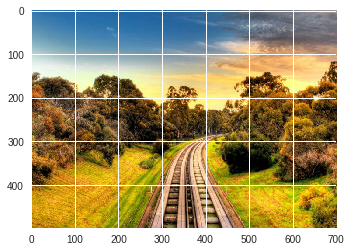

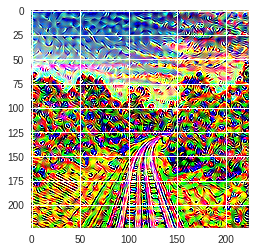

In [34]:


im = io.imread('deepdreamscene.jpg')
img = deep_dream(im, layer=8, iteration=10, lr=0.1)

plt.imshow(im)
plt.show()
plt.imshow(img)
plt.show()